# Speech Emotion Recognition using the RAVDESS AND TESS dataset

For this task, I have used 5252 samples from

the Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) dataset
the Toronto emotional speech set (TESS) dataset
The samples include:

**1440 **speech files and **1012** Song files from **RAVDESS**. This dataset includes recordings of 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech includes calm, happy, sad, angry, fearful, surprise, and disgust expressions, and song contains calm, happy, sad, angry, and fearful emotions. Each file was rated 10 times on emotional validity, intensity, and genuineness. Ratings were provided by 247 individuals who were characteristic of untrained adult research participants from North America. A further set of 72 participants provided test-retest data. High levels of emotional validity, interrater reliability, and test-retest intrarater reliability were reported. Validation data is open-access, and can be downloaded along with our paper from PLoS ONE.

**2800** files from **TESS**. A set of 200 target words were spoken in the carrier phrase "Say the word _____' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). There are 2800 stimuli in total. Two actresses were recruited from the Toronto area. Both actresses speak English as their first language, are university educated, and have musical training. Audiometric testing indicated that both actresses have thresholds within the normal range.

Mounting Drive so that we can access the contents directly from the drive

Importing Librosa library(A python package) for extracting important features of the audio like the pitch,tone.

In [1]:
#!pip install librosa

Loading one audio file from the drive using librosa.
Librosa loads the audio file as a floating point time series.

In [2]:
import librosa
from librosa import display

#data, sampling_rate = librosa.load('/content/drive/My Drive/Ravtess/03-02-06-02-02-02-04.wav')

Plotting the audio file which was just loaded by librosa using waveplot function of librosa.This Function Plots the amplitude envelope of a waveform.

In [3]:
# % pylab inline
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 4))
# librosa.display.waveplot(data, sr=sampling_rate)

# Load all files

We will create our numpy array extracting Mel-frequency cepstral coefficients (MFCCs), while the classes to predict will be extracted from the name of the file (see the introductory section of this notebook to see the naming convention of the files of this dataset).

In [7]:
import time
import os
path = './Rav'
lst = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        file = int(file[7:8]) - 1 
        arr = mfccs, file
        lst.append(arr)
      # If the file is not valid, skip it
      except ValueError:
        continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

ModuleNotFoundError: No module named 'resampy'

This error is lazily reported, having originally occured in
  File c:\Users\nikhi\Documents\C Project\EmoTunes-master\flask\lib\site-packages\librosa\core\audio.py, line 32, in <module>

----> resampy = lazy.load("resampy")

In [ ]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*lst)

In [ ]:
import numpy as np
X = np.asarray(X)
y = np.asarray(y)


X.shape, y.shape

((5252, 40), (5252,))

In [ ]:
# Saving joblib files to not load them again with the loop above

import joblib

X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = './Ravtess_model'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

In [ ]:
# Loading saved models
import joblib
X = joblib.load('./Ravtess_model/X.joblib')
y = joblib.load('./Ravtess_model/y.joblib')

# Decision Tree Classifier

To make a first attempt in accomplishing this classification task I chose a decision tree:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dtree = DecisionTreeClassifier()

In [ ]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
predictions = dtree.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.82      0.79      0.80       190
           1       0.61      0.54      0.57       117
           2       0.65      0.65      0.65       266
           3       0.72      0.75      0.73       246
           4       0.71      0.73      0.72       265
           5       0.64      0.65      0.65       246
           6       0.59      0.66      0.62       202
           7       0.69      0.60      0.64       202

    accuracy                           0.68      1734
   macro avg       0.68      0.67      0.67      1734
weighted avg       0.68      0.68      0.68      1734



# Neural network

In [ ]:
import numpy as np
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [ ]:
x_traincnn.shape, x_testcnn.shape

((3518, 40, 1), (1734, 40, 1))

In [ ]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

model = Sequential()

model.add(Conv1D(64, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(256, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00005, rho=0.9, epsilon=1e-07, decay=0.0)

Using TensorFlow backend.


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 40, 64)            384       
_________________________________________________________________
activation_1 (Activation)    (None, 40, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 64)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 128)           41088     
_________________________________________________________________
activation_2 (Activation)    (None, 10, 128)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 128)          

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=200, validation_data=(x_testcnn, y_test))

Train on 3518 samples, validate on 1734 samples
Epoch 1/200
3518/3518 [==============================] - 4s 1ms/step - loss: 3.4102 - accuracy: 0.1848 - val_loss: 1.8985 - val_accuracy: 0.3610
Epoch 2/200
3518/3518 [==============================] - 4s 1ms/step - loss: 2.2503 - accuracy: 0.3110 - val_loss: 1.4561 - val_accuracy: 0.5127
Epoch 3/200
3518/3518 [==============================] - 4s 1ms/step - loss: 1.8465 - accuracy: 0.4073 - val_loss: 1.4126 - val_accuracy: 0.5283
Epoch 4/200
3518/3518 [==============================] - 4s 1ms/step - loss: 1.6013 - accuracy: 0.4687 - val_loss: 1.2565 - val_accuracy: 0.5577
Epoch 5/200
3518/3518 [==============================] - 4s 1ms/step - loss: 1.4437 - accuracy: 0.5122 - val_loss: 1.2132 - val_accuracy: 0.5686
Epoch 6/200
3518/3518 [==============================] - 4s 1ms/step - loss: 1.3279 - accuracy: 0.5389 - val_loss: 1.1017 - val_accuracy: 0.6136
Epoch 7/200
3518/3518 [==============================] - 4s 1ms/step - loss: 1.266

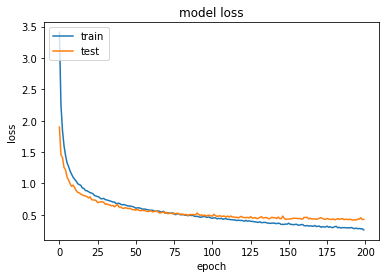

In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

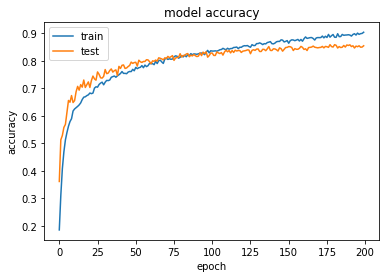

In [ ]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict_classes(x_testcnn)

In [ ]:
predictions

array([3, 4, 3, ..., 2, 3, 5])

In [ ]:
y_test

array([3, 4, 3, ..., 2, 3, 5])

In [ ]:
new_Ytest = y_test.astype(int)

In [ ]:
new_Ytest

array([3, 4, 3, ..., 2, 3, 5])

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(new_Ytest, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       190
           1       0.77      0.76      0.76       117
           2       0.90      0.84      0.87       266
           3       0.80      0.86      0.83       246
           4       0.89      0.88      0.88       265
           5       0.88      0.80      0.84       246
           6       0.81      0.92      0.86       202
           7       0.88      0.85      0.86       202

    accuracy                           0.85      1734
   macro avg       0.85      0.85      0.85      1734
weighted avg       0.86      0.85      0.85      1734



In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(new_Ytest, predictions)
print (matrix)

# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised

[[172   5   1   8   0   0   1   3]
 [  6  89   5   9   0   0   6   2]
 [  4   6 223   5   8   8   3   9]
 [  7   7   3 212   3   8   4   2]
 [  1   2   4   2 232   8  15   1]
 [  0   1   6  23  10 196   8   2]
 [  1   2   0   2   5   1 186   5]
 [  5   4   6   4   2   1   8 172]]


In [ ]:
model.save('testing_model.h5')
print("MODEL SAVED")

MODEL SAVED


In [ ]:
new_model=keras.models.load_model('testing_model.h5')
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 40, 64)            384       
_________________________________________________________________
activation_1 (Activation)    (None, 40, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 64)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 128)           41088     
_________________________________________________________________
activation_2 (Activation)    (None, 10, 128)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 128)          

In [ ]:
loss, acc = new_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

1734/1734 [==============================] - 0s 95us/step
Restored model, accuracy: 85.47%
